# HighResNet

In [1]:
# installs
!pip install monai # model
!pip install medmnist # data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=57ead3e8f832fd9175ef51f646e4af0fa069001538d087589c7b907e7ae11dcc
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [11]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from medmnist import RetinaMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from monai.networks import nets
from torchvision import transforms
from monai.networks.nets import HighResNet

import monai
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load Dataset

In [12]:
# load RetinaMNIST dataset
def get_retina_mnist_data(split, transform=None):
    return RetinaMNIST(split=split, transform=transform, download=True, as_rgb=True)

# preprocessing transformation for the RetinaMNIST images
transform = transforms.Compose([
    transforms.Resize(256),  # resize the image to at least 256 pixels in the smaller dimension
    transforms.CenterCrop(224),  # crop the center of the image to 224x224 pixels (required by HighResNet)
    transforms.ToTensor(),  # convert the image to a PyTorch tensor (values scaled to [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize using ImageNet stats
])

# load train and validation splits
train_dataset = get_retina_mnist_data("train", transform)
val_dataset = get_retina_mnist_data("val", transform)

Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


## Dataloaders

In [13]:
# define batch size
batch_size = 32
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Define Model

In [14]:
class HighResNetForClassification(nn.Module):
    def __init__(self, spatial_dims=2, in_channels=3, out_channels=5):
        super(HighResNetForClassification, self).__init__()
        # Initialize the HighResNet model
        self.highresnet = HighResNet(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=out_channels
        )
        # Add a Global Average Pooling layer followed by a fully connected layer
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling (output: 1x1 spatial size)
        self.fc = nn.Linear(out_channels, out_channels)  # Final classification layer (output: [batch_size, num_classes])

    def forward(self, x):
        # Forward pass through the HighResNet
        x = self.highresnet(x)
        # Apply Global Average Pooling to reduce spatial dimensions
        x = self.pool(x)
        # Flatten the output to pass it to the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, out_channels]
        x = self.fc(x)  # Final classification layer
        return x

# Instantiate the modified model
model = HighResNetForClassification(spatial_dims=2, in_channels=3, out_channels=5)

In [15]:
# move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

HighResNetForClassification(
  (highresnet): HighResNet(
    (blocks): Sequential(
      (0): Convolution(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (adn): ADN(
          (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (A): ReLU(inplace=True)
        )
      )
      (1): HighResBlock(
        (chn_pad): ChannelPad()
        (layers): Sequential(
          (0): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (A): ReLU(inplace=True)
          )
          (1): Convolution(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (2): ADN(
            (N): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (A): ReLU(inplace=True)
          )
          (3): Convolution(
            (conv): Conv2d(16, 16, kernel_size=(3,

In [16]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # cross-entropy loss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # adam optimizer

## Train

In [17]:
# training loop
num_epochs = 200
train_acc = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)

        optimizer.zero_grad()  # Zero the gradients before each backward pass
        outputs = model(inputs)  # Forward pass

        # Ensure labels are in correct format
        labels = labels.squeeze()  # Ensure labels are [batch_size]

        # Compute the loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (max along the class dimension)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total  # Calculate accuracy
    train_acc.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/200, Loss: 1.4698, Accuracy: 43.33%
Epoch 2/200, Loss: 1.4076, Accuracy: 49.91%
Epoch 3/200, Loss: 1.3695, Accuracy: 48.98%
Epoch 4/200, Loss: 1.3417, Accuracy: 48.98%
Epoch 5/200, Loss: 1.3133, Accuracy: 49.81%
Epoch 6/200, Loss: 1.2861, Accuracy: 50.19%
Epoch 7/200, Loss: 1.2711, Accuracy: 49.63%
Epoch 8/200, Loss: 1.2484, Accuracy: 50.19%
Epoch 9/200, Loss: 1.2344, Accuracy: 49.72%
Epoch 10/200, Loss: 1.2181, Accuracy: 49.72%
Epoch 11/200, Loss: 1.2095, Accuracy: 50.28%
Epoch 12/200, Loss: 1.1980, Accuracy: 52.78%
Epoch 13/200, Loss: 1.2038, Accuracy: 49.81%
Epoch 14/200, Loss: 1.1871, Accuracy: 50.09%
Epoch 15/200, Loss: 1.1767, Accuracy: 50.93%
Epoch 16/200, Loss: 1.1825, Accuracy: 51.11%
Epoch 17/200, Loss: 1.1831, Accuracy: 50.37%
Epoch 18/200, Loss: 1.1763, Accuracy: 51.02%
Epoch 19/200, Loss: 1.1767, Accuracy: 51.85%
Epoch 20/200, Loss: 1.1669, Accuracy: 51.20%
Epoch 21/200, Loss: 1.1674, Accuracy: 52.78%
Epoch 22/200, Loss: 1.1688, Accuracy: 51.76%
Epoch 23/200, Loss:

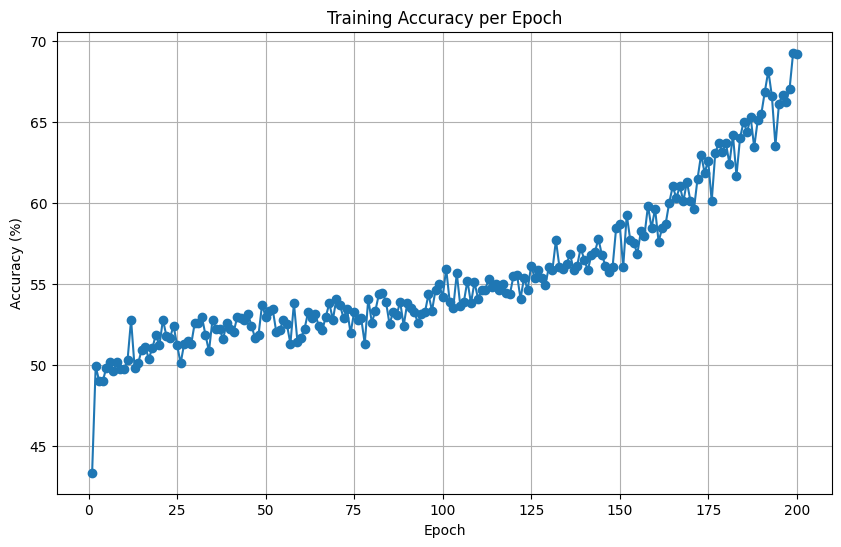

In [18]:
# Plot Training Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_acc, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy per Epoch")
plt.grid()
plt.show()

## Display Example Predictions

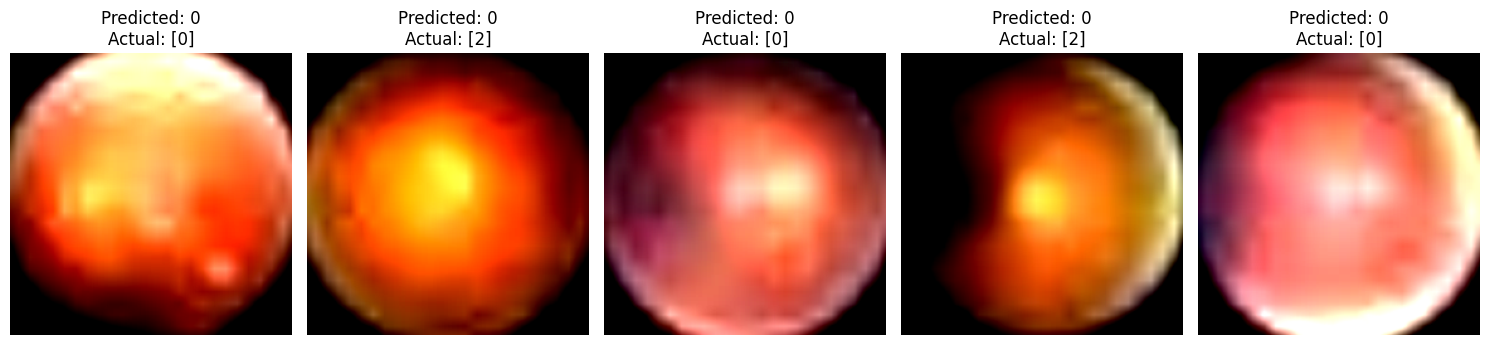

In [19]:
import random
import matplotlib.pyplot as plt

# Function to display random samples with predictions and actual labels
def visualize_predictions(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    # loop over each randomly selected sample index
    for i, idx in enumerate(samples):
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            output = model(image_tensor)
            predicted_label = torch.argmax(output, 1).item()

        # move the image back to CPU for visualization
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 0.5) + 0.5  # undo normalization for visualization
        # plot the image on the corresponding axis
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, val_dataset, num_samples=5)

## Confusion Matrix

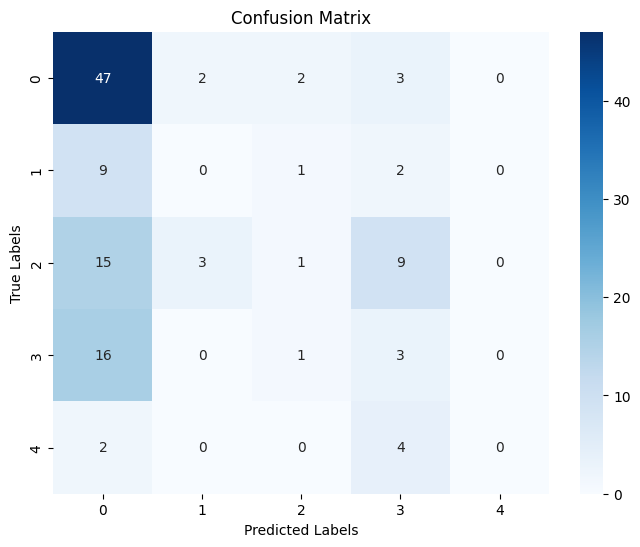

In [20]:
# plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# generate confusion matrix
def generate_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No need to track gradients during inference
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(predicted.cpu().numpy())  # Store predicted labels

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Define the class names (adjust if necessary based on your dataset)
    class_names = [str(i) for i in range(5)]  # Assuming 5 classes (0 to 4)

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)

generate_confusion_matrix(model, val_loader)

## Saliency

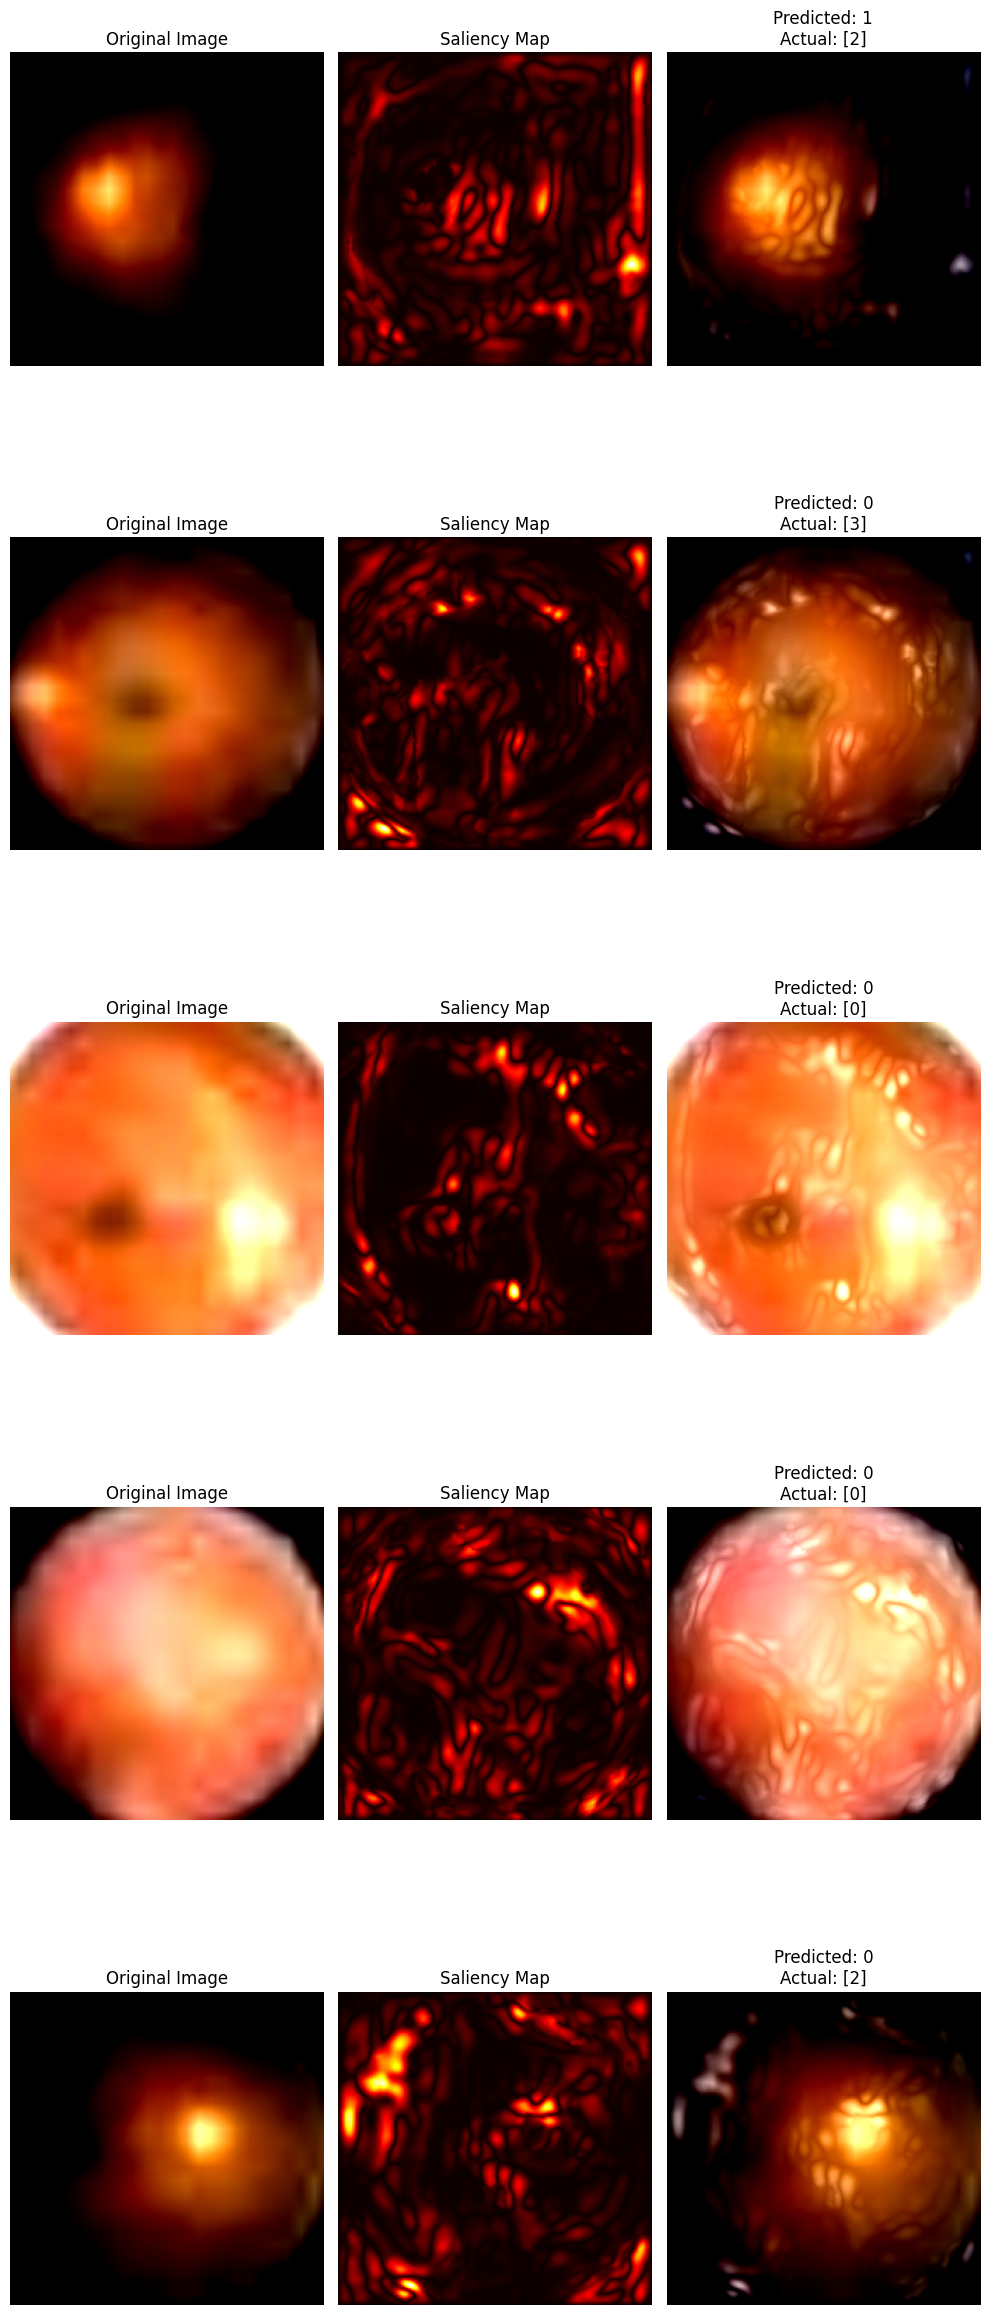

In [21]:
def visualize_saliency(model, dataset, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(dataset)), num_samples)  # Randomly sample from the dataset

    # Create a subplot grid (num_samples rows, 3 columns for original, saliency map, and overlay)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

    for i, idx in enumerate(samples):
        image, label = dataset[idx]  # Get the image and its label from the dataset
        image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to the device (GPU/CPU)

        image_tensor.requires_grad_()  # Enable gradient tracking for the image tensor

        # Forward pass to get model predictions
        output = model(image_tensor)  # Forward pass through the model
        predicted_label = torch.argmax(output, 1).item()  # Get the predicted class

        # Compute gradients of the output w.r.t the input image
        model.zero_grad()  # Reset gradients from the previous backward pass
        output[0, predicted_label].backward()  # Backpropagate to get the gradient for the predicted class
        saliency = image_tensor.grad.abs().squeeze().cpu().numpy()  # Get the saliency map (absolute gradient)

        # Normalize the saliency map (optional but useful for visualization)
        saliency = saliency.max(axis=0)  # Take the maximum saliency value across channels (for RGB)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0, 1]

        # Undo normalization for the original image (to bring it back to [0, 1] for display)
        image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert the image to numpy (H, W, C)
        image_np = (image_np * 0.5) + 0.5  # Undo the normalization (from [-1, 1] back to [0, 1])

        # Overlay saliency map on top of the original image
        overlay = np.clip(image_np + np.expand_dims(saliency, axis=-1), 0, 1)  # Combine saliency with the image

        # Plot the original image, the saliency map, and the overlay
        axes[i, 0].imshow(image_np)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original Image")

        axes[i, 1].imshow(saliency, cmap="hot")  # Display the saliency map with a 'hot' colormap
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Saliency Map")

        axes[i, 2].imshow(overlay)  # Display the image with the saliency map overlaid
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Predicted: {predicted_label}\nActual: {label}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Call the function to visualize saliency maps on the validation dataset
visualize_saliency(model, val_dataset, num_samples=5)